
# ROOM OCCUPANCY PROJECT

This is a simple project aiming at estimating the occupancy (count) of a room using data recorded by different sensors (temperature, CO2, sound, light and motion) as a function of time.  
Data are based on a [paper published in IEEE](https://ieeexplore.ieee.org/document/8644432) and can be found on [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation).

We will first attempt to reproduce the results presented in the paper, then we will try to improve the results using feature engineering and by building more complex models.

## Imports

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")
from sklearnex import patch_sklearn
patch_sklearn()
from room_occupancy_module import (read_file_df, plot_columns_index_occupancy, plot_onecolumn_index_occupancy,
                                   plot_one_columns_index_occupancy_compare_transformation, plot_confusion_acc_f1)
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# preprocessing
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import (GridSearchCV, cross_val_predict, 
                                RandomizedSearchCV, StratifiedKFold,
                                StratifiedGroupKFold, cross_validate)    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

from transformers import Window_Average_w_Edges

## Data Collection

Save data from URL to dataframe `df`.

In [3]:
file_path = 'https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip'
df = read_file_df(file_path)

In [4]:
df.head(1)

,date,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017-12-22 10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  10129 non-null  datetime64[ns]
 1   S1_Temp               10129 non-null  float64       
 2   S2_Temp               10129 non-null  float64       
 3   S3_Temp               10129 non-null  float64       
 4   S4_Temp               10129 non-null  float64       
 5   S1_Light              10129 non-null  int64         
 6   S2_Light              10129 non-null  int64         
 7   S3_Light              10129 non-null  int64         
 8   S4_Light              10129 non-null  int64         
 9   S1_Sound              10129 non-null  float64       
 10  S2_Sound              10129 non-null  float64       
 11  S3_Sound              10129 non-null  float64       
 12  S4_Sound              10129 non-null  float64       
 13  S5_CO2          

All features are numerical and target `Room_Occupacy_Count` is multi-class (int from 0 to 4). We'll leave it as an `int` to plot it more easily.

In [6]:
df['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

Classes are unbalanced, we will need to use stratification and rely on F1-score in the validation process.

In [7]:
df.isnull().sum()

date                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

No missing data in the dataset, they were removed beforehand by the authors.

### Target Column

Let's take a loot at the target columns `Room_Occupancy_Count` as a function of time and as of function of the index.

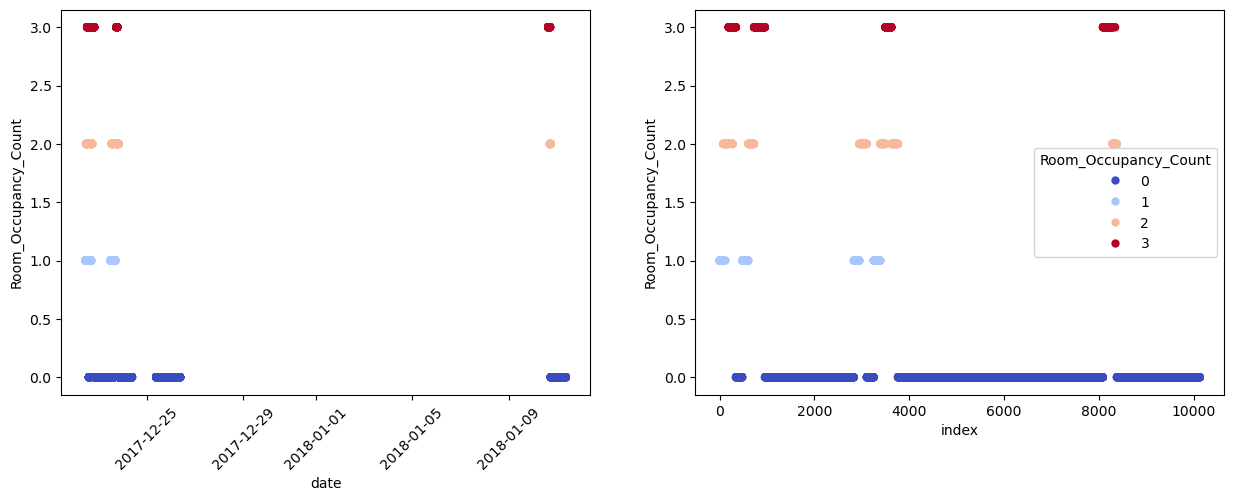

In [8]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(ax=axs[0], data=df, x='date', y='Room_Occupancy_Count', hue='Room_Occupancy_Count', palette='coolwarm', edgecolor="none", legend=False)
sns.scatterplot(ax=axs[1], data=df, x=df.index, y='Room_Occupancy_Count', hue='Room_Occupancy_Count', palette='coolwarm', edgecolor="none", legend=True)
axs[1].set_xlabel('index')
axs[0].tick_params(axis="x", labelrotation=45);

There is large time gap between two experiments, one carried out in 2017 and the other in 2018. Looking at features *vs* index will be more useful. Since our goal here is not to forecast the occupancy count but to predict its value at a given time, we can safely drop the `date` column.

In [9]:
df= df.drop(columns='date')

## Previous Results

Before attempting to improve the model described in the paper, we will try to reproduce the presented results. To get the best accuracy and f1 score combo, the authors used a SVC with the rbf kernel. They write:  "*Metrics such as accuracy, F1 score and confusion matrix were evaluated using 10-fold cross validation. Since the data is of time-series nature, data was not shuffled prior to cross validation to avoid data points similar to test data getting into the training data*". Macro average was use to compute f1-score. This seems to correspond to what one would get  using `StratifiedKFold` with 10 splits and `cross_val_predict` to evaluate the metrics on the whole dataset. 

In [10]:
skf = StratifiedKFold(n_splits=10)

In [11]:
X_base = df.copy()
y = X_base.pop('Room_Occupancy_Count')
groups = np.zeros_like(y) # We will use groups at some point, but for now we use the same for all instances.

In [12]:
X_base.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

The study does not report the optimal parameters for the SVC classifier, we'll use `GridSearchCV` to figure them out. Cross valitation is equivalent to default `cv=10`, which is 10-fold stratified cross validation without shuffling.

In [13]:
svc_pipeline_1 = Pipeline([
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())
])

# best parameters
svc_param_grid_1 = [{
'svc_rbf__C':[10],
'svc_rbf__gamma':[0.001]
}]

# for gridsearch
# svc_param_grid_1 = [{
# 'svc_rbf__C':[1,10,100],
# 'svc_rbf__gamma':[0.01,0.001,0.0001]
# }]

svc_grid_1 = GridSearchCV(svc_pipeline_1, svc_param_grid_1, scoring='f1_macro', cv=skf, n_jobs=-1)
svc_grid_1.fit(X_base, y, groups=groups)

std_svc_best_1 = svc_grid_1.best_estimator_
std_svc_best_1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.001))])

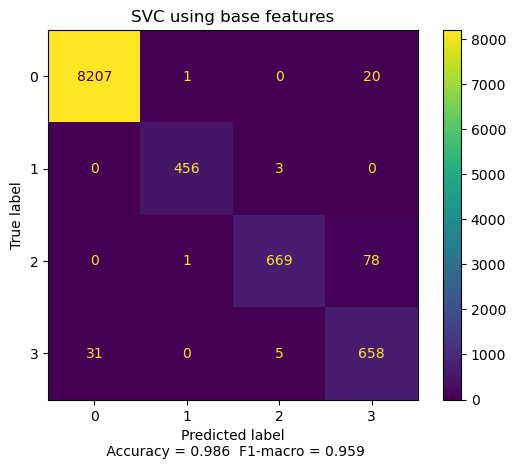

In [14]:
svc_predictions_1 = cross_val_predict(std_svc_best_1, X_base, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, svc_predictions_1, 'SVC using base features')

The best model is obtained for $C=10$ and $\gamma = 0.001$, which provides an accuracy of 0.986 and f1_macro score of 0.959. These results are extremely close to the 0.984 accuracy and 0.953 macro f1-score reported in the paper.

## Data Exploration and Feature Engineering

Now, we will attempt to improve the model's accuracy and f1 score by:
- Enhancing feature engineering
- Tweaking the model

Let's first take a close look at the features

In [15]:
X_base.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

Features can be grouped by sensor types: temperature, light, sound, CO2 level and infrared (PIR). We group the columns names by type: `temp_features`,  `light_features`, `sound_features`,`CO2_features` and `PIR_features` for easy access.

In [16]:
temp_features = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']
light_features = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']
sound_features = ['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']
CO2_features = ['S5_CO2', 'S5_CO2_Slope']
PIR_features = ['S6_PIR', 'S7_PIR']

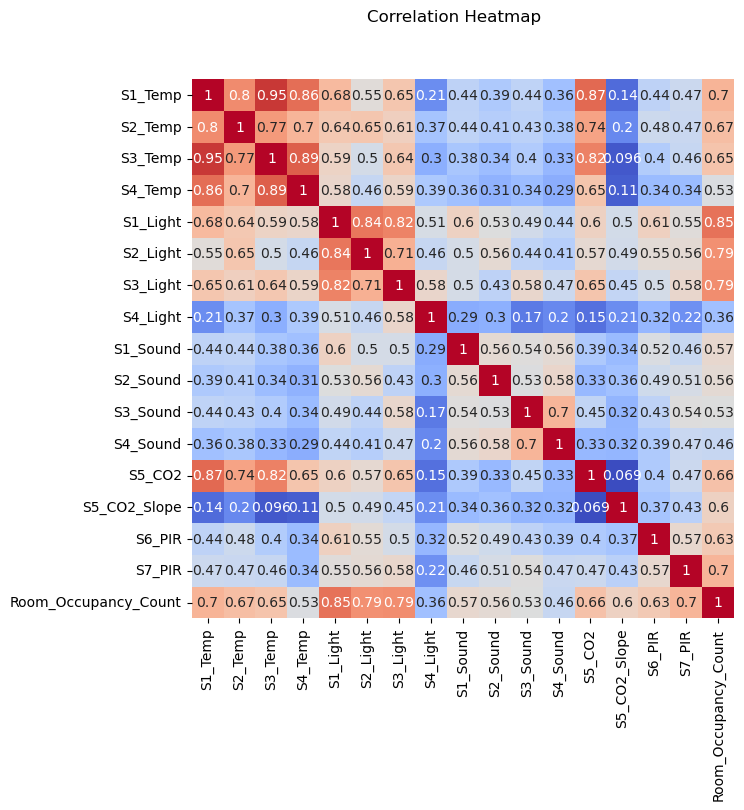

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.heatmap(df.corr(), ax=ax, cbar=False, cmap='coolwarm', annot=True)
fig.suptitle('Correlation Heatmap');

Without too much surprise, the sensors response for the same sensor types are highly correlated. It could make sense to use the average sensor response instead of each indivudal sensor response.

### Temperature features

Let's look at the evolution of the signal from the temperature sensors.

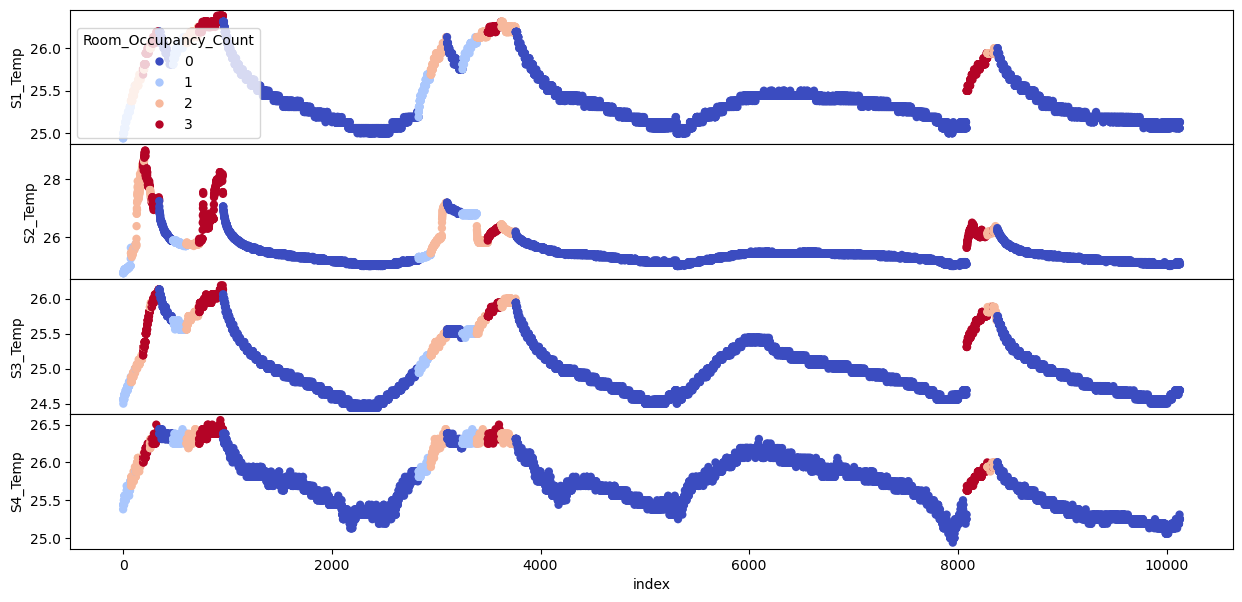

In [18]:
plot_columns_index_occupancy(df, temp_features)

It looks like occupancy has an impact on the rate of change of the temperature, but the overal response depends a lot on history. Maybe the average temperature over the four sensors could be interesting to look at.

We create a new dataframe `df_avg` for the new features we will add: the average sensor response for each sensor type.

In [19]:
df_avg = df[['Room_Occupancy_Count']].copy()

Adding a column `avg_temp` representing the average temperature of the four sensors.

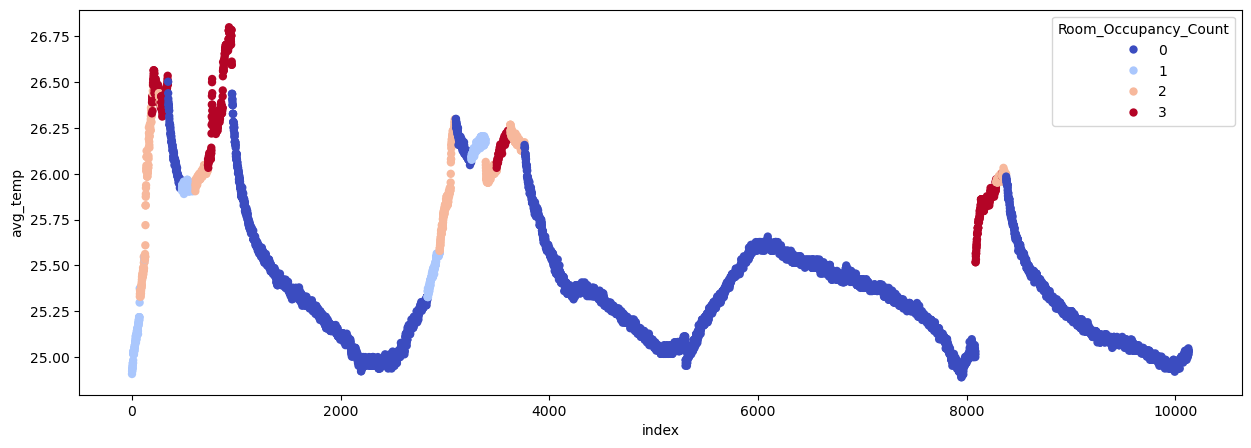

In [20]:
df_avg['avg_temp'] = df[temp_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg, 'avg_temp')

### Light features

We do the same for the lights sensors.

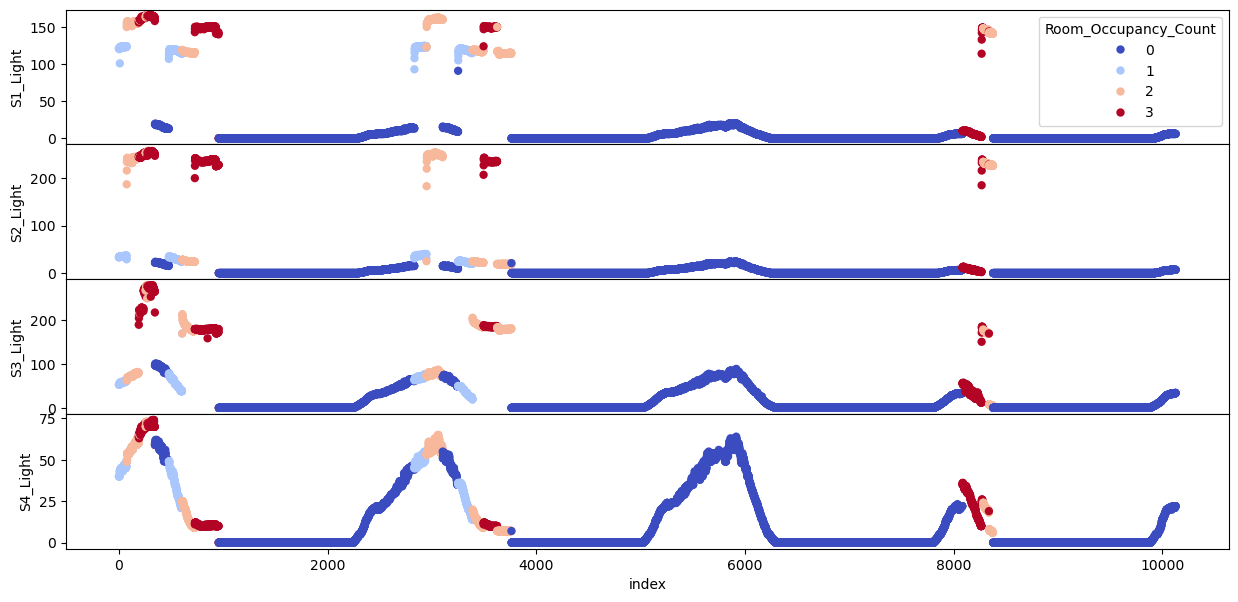

In [21]:
plot_columns_index_occupancy(df, light_features)

Adding a column `avg_light` representing the average light of the four sensors.

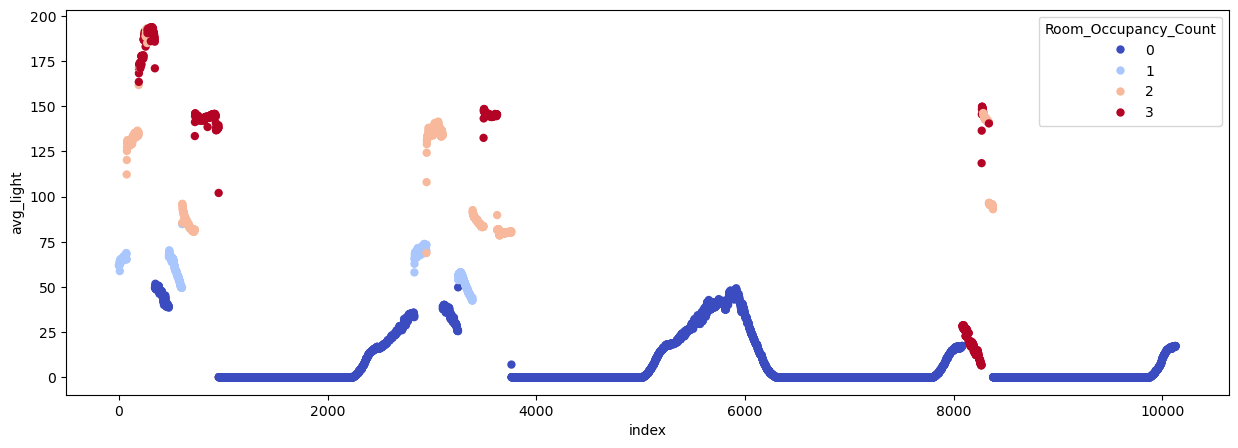

In [22]:
df_avg['avg_light'] = df[light_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg, 'avg_light')

Looking at `avg_light`, we can roughly determine the room occupancy by setting threshold values of 50, 100 and 150. This feature will probably help classification.

### Sound Features

Now for the sound features.

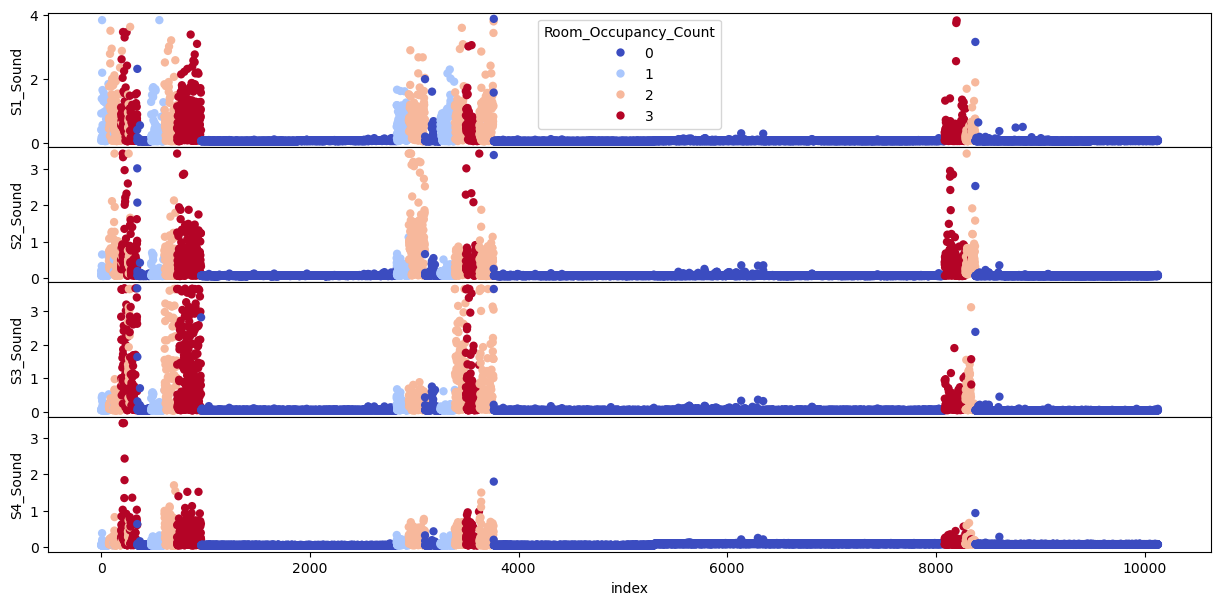

In [23]:
plot_columns_index_occupancy(df, sound_features)

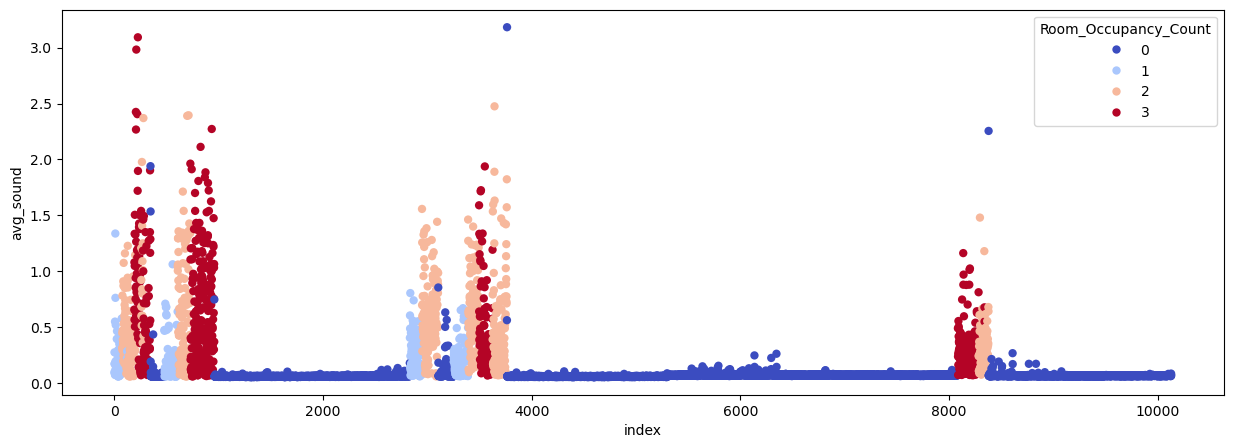

In [24]:
df_avg['avg_sound'] = df[sound_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg, 'avg_sound')

### CO2 features

The CO2 slope was extracted using a 25-points sliding window. Since the signal from other sensors can be quite noisy, ***it may be a good idea to also implement a sliding window average*** to smooth the other sensors response as well. We will need to implement it through a sk-learn transformer later to prevent data leakage from the sliding window.

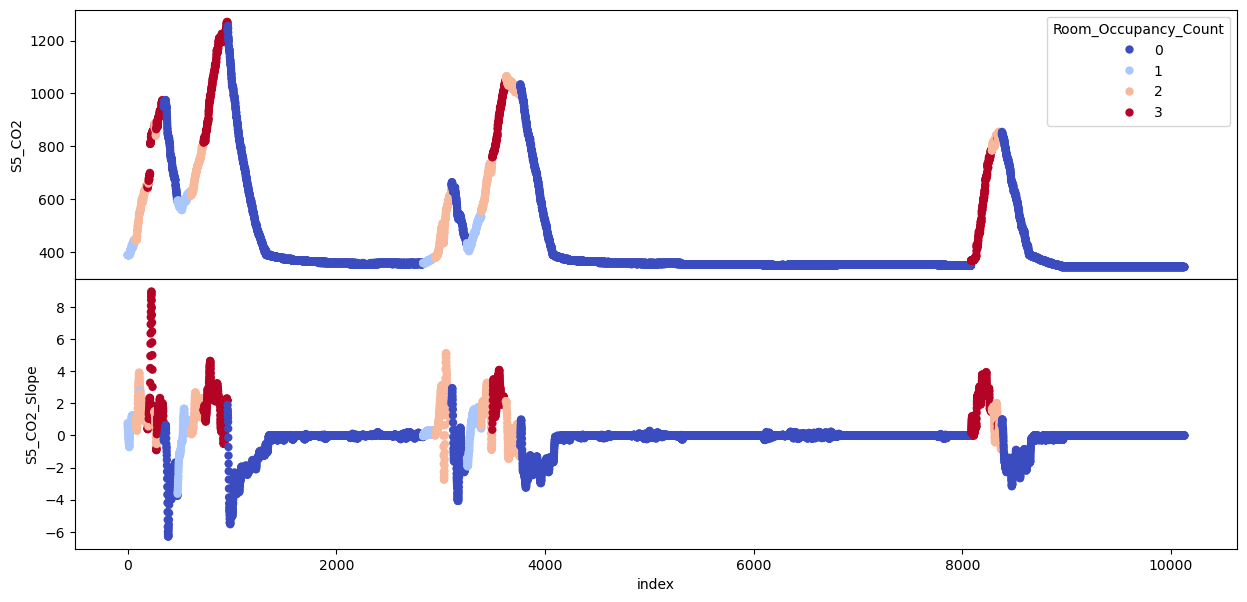

In [25]:
plot_columns_index_occupancy(df, CO2_features)

There are no multiple CO2 sensor signals we can average in this case.

### PIR Features

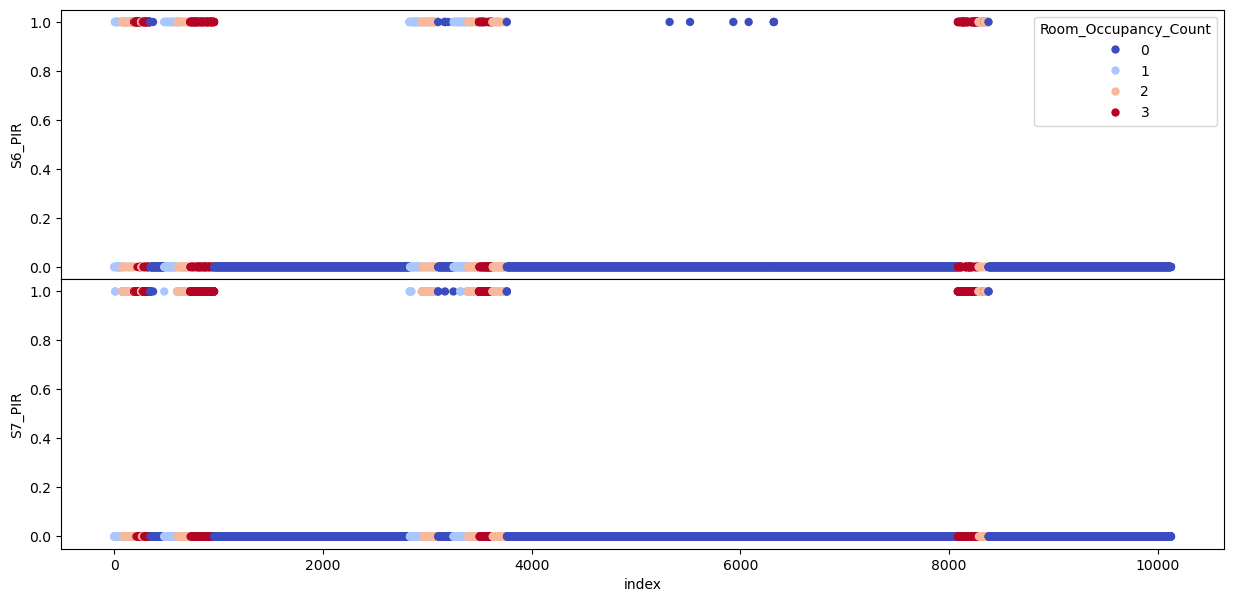

In [26]:
plot_columns_index_occupancy(df, PIR_features)

If we zoom in to see the indices below 1000, we see that the PIR signal fluctuates a lot when the occupancy is non zero. Using an rolling average would probably yield better prediction power for this feature.

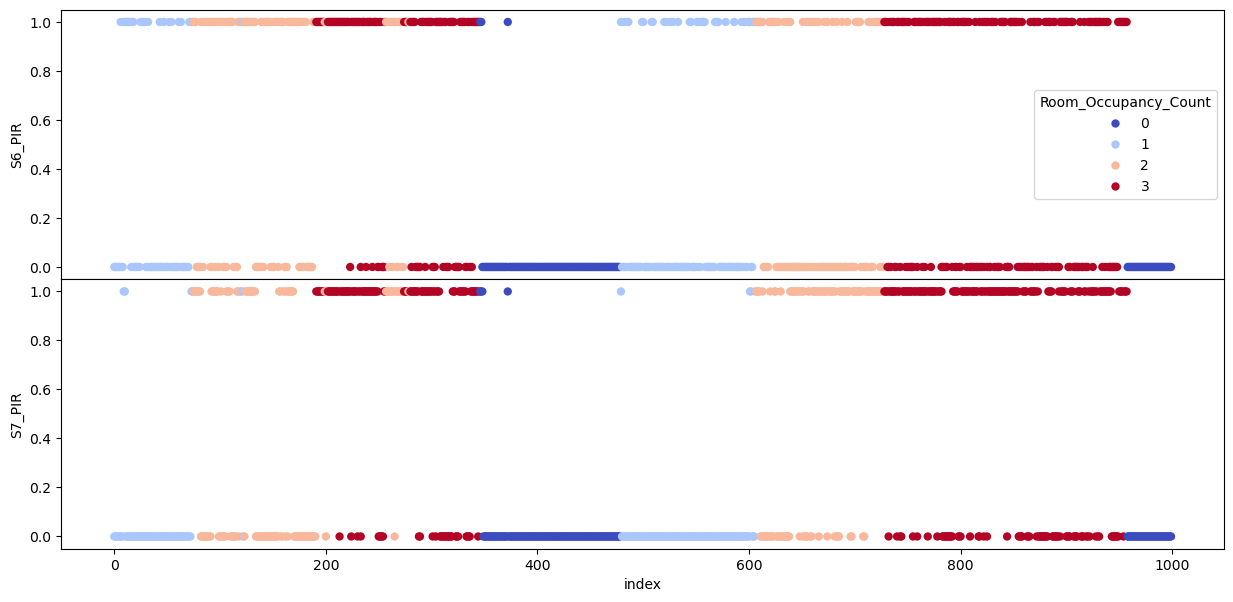

In [27]:
plot_columns_index_occupancy(df.query('index<1000'), PIR_features)

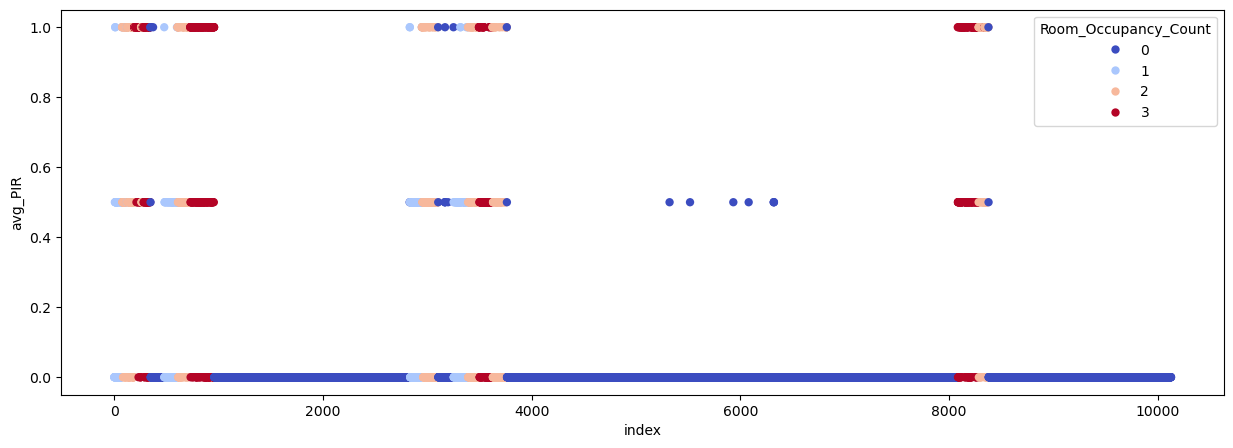

In [28]:
df_avg['avg_PIR'] = df[PIR_features].mean(axis=1)
plot_onecolumn_index_occupancy(df_avg, 'avg_PIR')

### Averaging window

We'll quickly see if using an averaging windows yields significantly different response. This will also impact the target, but we will take car of that during the prober model evaluation. We'll use the `Window_Average_w_Edges` transformer with a width of 25 points, as for the comutation of `CO2_Slope`.

In [35]:
window_averager = Window_Average_w_Edges(25)

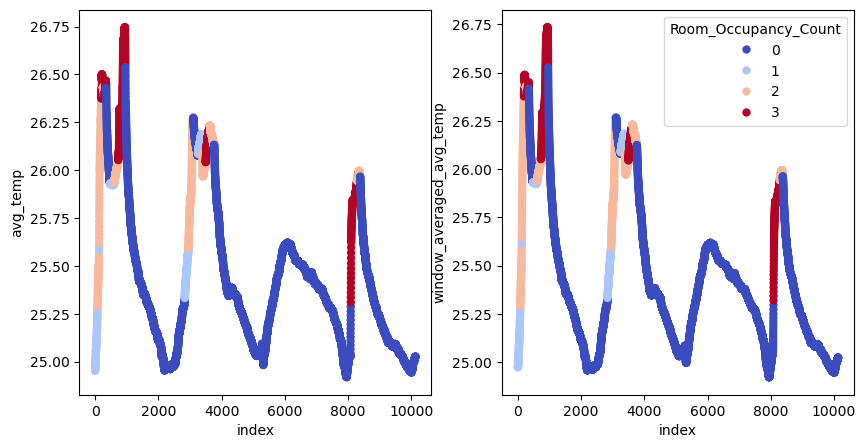

In [36]:
plot_one_columns_index_occupancy_compare_transformation(df_avg, 'avg_temp', window_averager)

Left plot shows raw data, right plot shows averaged results. There is no significant difference between the average temperature and its window-averaged counterpart. It makes sens since this variable changes smoothly over time.

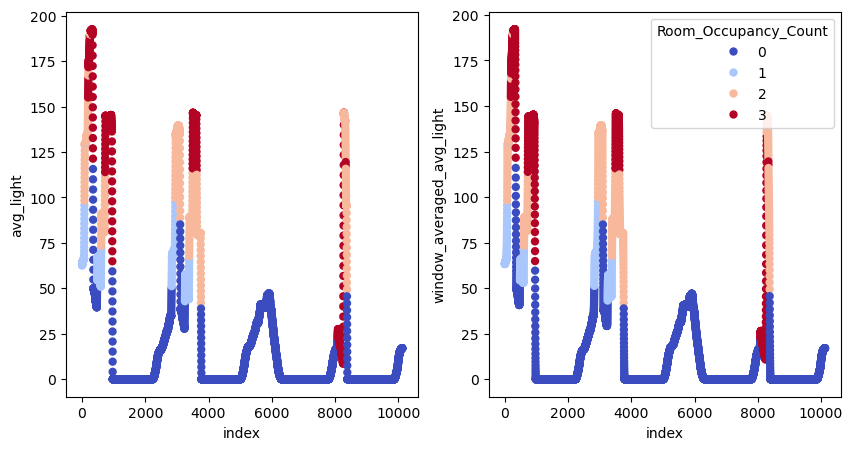

In [37]:
plot_one_columns_index_occupancy_compare_transformation(df_avg, 'avg_light', window_averager)

Class separation seems to be worse when adding the window average for light feature.

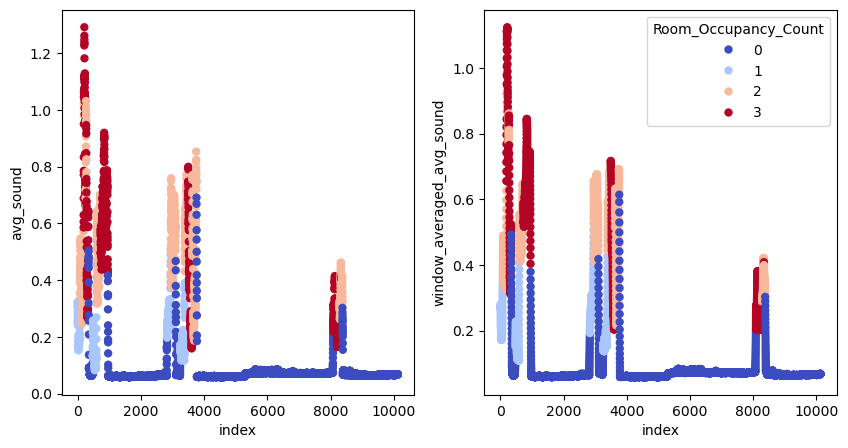

In [38]:
plot_one_columns_index_occupancy_compare_transformation(df_avg, 'avg_sound', window_averager)

Class separation also seems worse when adding the window average for sound feature.

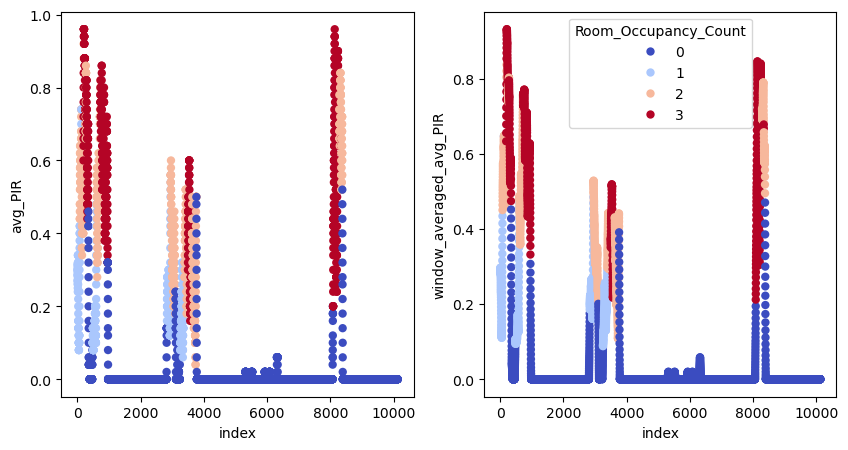

In [39]:
plot_one_columns_index_occupancy_compare_transformation(df_avg, 'avg_PIR', window_averager)

Class separation seems better when adding the window average to the PIR feature.

### Base + Sensor Average

We'll see if the base model performs better with the new features (column averages), then we'll try to add the window-averaged features.

In [263]:
X_base_avg = pd.concat([X_base, df_avg.drop(columns='Room_Occupancy_Count')], axis=1)

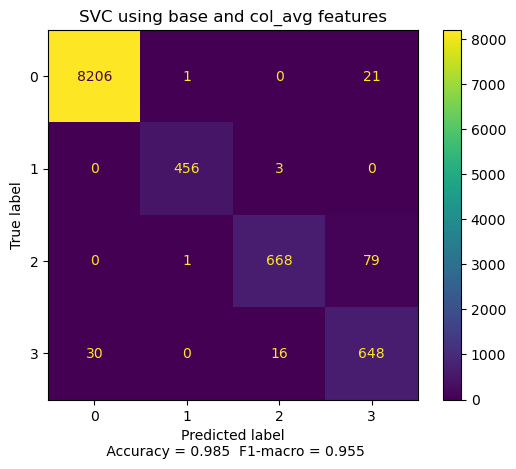

In [264]:
svc_predictions_2 = cross_val_predict(std_svc_best_1, X_base_avg, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, svc_predictions_2, 'SVC using base and col_avg features')

Performances are slightly worse. It seems that the column averages are not helping prediction.

### Base +  Window-averaged Average PIR

We'll add the window-averaged average PIR response as it seemed to yield better classe separation.

In [265]:
X_avg_PIR = pd.concat([X_base, df_avg['avg_PIR']], axis=1)

Window averaging is implemented in the model pipeline to prevent data leakage from test to train set through the slidding window. We will test three values for the window size : 1, 25 and 50 data points.

In [266]:
svc_pipeline_2 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR', Window_Average_w_Edges(25), ['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC(C=10, gamma=0.01))
])

# For grid search
# svc_param_grid_2 = [{
# 'averager__avg_PIR__window_size':[1,25,50],    
# }]

# Best results
svc_param_grid_2 = [{
'averager__avg_PIR__window_size':[25],    
}]

svc_grid_2 = GridSearchCV(svc_pipeline_2, svc_param_grid_2, scoring='f1_macro', cv=skf, n_jobs=-1)
svc_grid_2.fit(X_avg_PIR, y, groups=groups)

std_svc_best_2 = svc_grid_2.best_estimator_
std_svc_best_2

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average_w_Edges(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.01))])

Best results are obtained for a window size of 25 points.

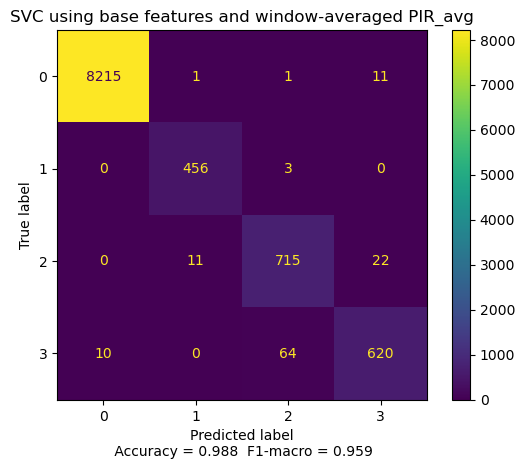

In [267]:
svc_predictions_2 = cross_val_predict(std_svc_best_2, X_avg_PIR, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_2, 'SVC using base features and window-averaged PIR_avg')

In a previous version, we had the impression that the model was performing much better when adding the window-averaged `avg_PIR`, going from 0.986 to 0.989 in accuracy and from 0.959 to 0.967 in macro f1 compared to the base model. This was using the `Window_Average` transformer, which was simply applying a 25-point average window on the selected features. As the stratified cross validation process leads to a segmentation of the time series, it made no sence to apply a window average to instances that were not consecutive in time. 

This has been fixed by replacing the transformer with the updated `Window_Average_w_Edges` that only applies the average window for instances with consecutive indices. Using this updated transformer, we only get a small improvement of accuracy, from 0.986 to 0.988, with the same f1_score. 

Overall, our model does a better job finding instances with an occupancy of 0 and 2, but is not as good at finding predicting full occupancy.

### Base with the two window-averaged PIR signals.

Let's see if applying the averaging window directly on the two PIR sensor signals improves the prediction.

In [268]:
svc_pipeline_3 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average_w_Edges(25),['S7_PIR','S6_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC(C=10, gamma=0.01))
])

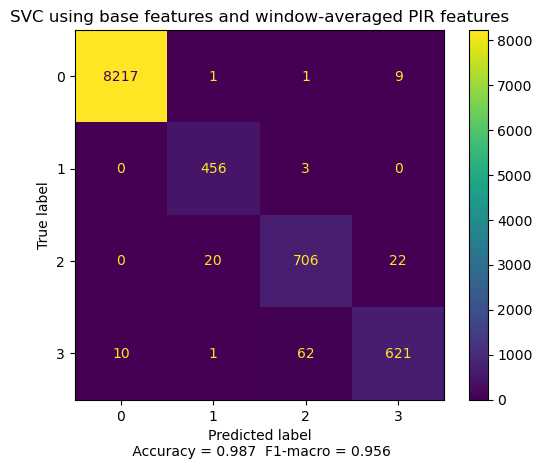

In [269]:
svc_predictions_3 = cross_val_predict(svc_pipeline_3, X_base, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, svc_predictions_3, 'SVC using base features and window-averaged PIR features')

The model performs better than with the base features in terms of accuracy, but is not as good in terms of f1-score. Overall, the model's best performances are obtained using the base features, plus the window_averaged `avg_PIR`.

We will keep `X_avg_PIR` containing base feature and window-averaged `avg_PIR` as our test dataframe for tuning the model.

## Models

We will now train various models (KNN, RF, LGBM and LDA) hpping to outperform the SVM classifier. We will then combine them into a voting classifier to try to improve prediction performance.

### KNN

In [270]:
knn_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average_w_Edges(25), ['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# For gridsearch
# knn_param_grid = [{
#     'knn__n_neighbors':[1,2,3,4,5,6,7,10,50],
#     'knn__weights' : ['uniform', 'distance'],
#     'knn__p':[1,2]
# }]

# Best parameters
knn_param_grid = [{
    'knn__n_neighbors': [3],
    'knn__weights': ['uniform'],
    'knn__p': [2]
}]

knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, scoring='f1_macro' ,cv=skf, n_jobs=-1)
knn_grid.fit(X_avg_PIR, y, groups=groups)

std_knn_best_1 = knn_grid.best_estimator_
std_knn_best_1

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average_w_Edges(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

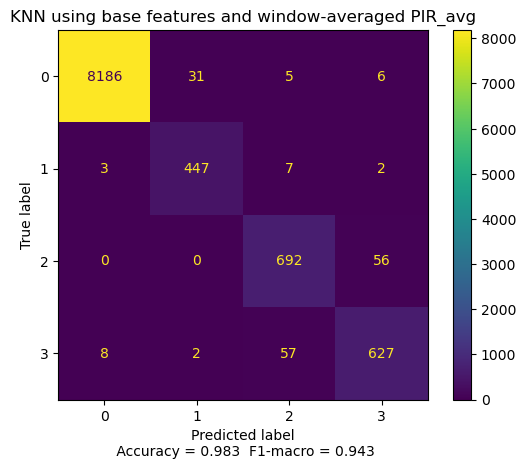

In [271]:
knn_predictions = cross_val_predict(std_knn_best_1, X_avg_PIR, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, knn_predictions, 'KNN using base features and window-averaged PIR_avg')

### Random Forest

In [272]:
rf_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR', Window_Average_w_Edges(25), ['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

# # For random gridsearch
# rf_random_grid = {'rfc__bootstrap': [True, False],
#                'rfc__max_depth': [5,10, 20,50, 100, None],
#                'rfc__max_features': [1.0, 'sqrt'],
#                'rfc__min_samples_leaf': [ 2, 4, 8],
#                'rfc__min_samples_split': [2, 5, 10],
#                'rfc__n_estimators': [100, 200, 500, 1000]}

# Best params
rf_random_grid = {'rfc__bootstrap': [False],
               'rfc__max_depth': [5],
               'rfc__max_features': ['sqrt'],
               'rfc__min_samples_leaf': [8],
               'rfc__min_samples_split': [2],
               'rfc__n_estimators': [200]}

rf_grid = RandomizedSearchCV(rf_pipeline, rf_random_grid, n_iter=200, cv=skf, n_jobs=-1, verbose=1)
rf_grid.fit(X_avg_PIR, y, groups=groups)
std_rf_best = rf_grid.best_estimator_
std_rf_best

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average_w_Edges(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        min_samples_leaf=8,
                                        n_estimators=200))])

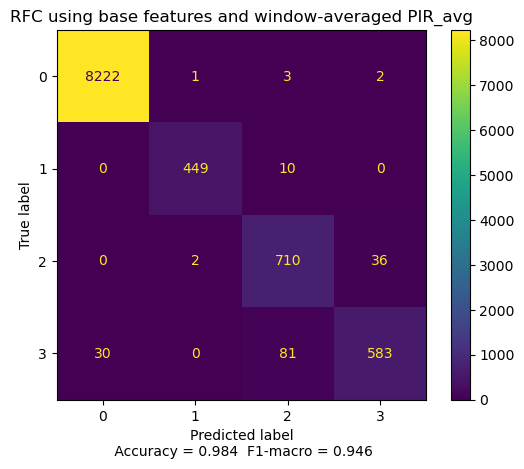

In [273]:
rf_predictions = cross_val_predict(std_rf_best, X_avg_PIR, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, rf_predictions, 'RFC using base features and window-averaged PIR_avg')

### LGBM

In [274]:
lgbm_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average_w_Edges(25), PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('lgbm', LGBMClassifier(verbose=-1))
   ])

# For gridsearch
# lgbm_param_grid =  {
#     'lgbm__num_leaves': [31,100],
#     'lgbm__max_depth': [-1,5],
#     'lgbm__learning_rate' : [0.2,0.1,0.05],
#     'lgbm__n_estimators': [50,100,200]
#     }

# Best params
lgbm_param_grid =  {
    'lgbm__num_leaves': [31],
    'lgbm__max_depth': [5],
    'lgbm__learning_rate': [0.05],
    'lgbm__n_estimators': [100]
    }

In [275]:
lgbm_grid = GridSearchCV(estimator=lgbm_pipeline, param_grid=lgbm_param_grid, scoring='f1_macro', n_jobs=-1, cv=skf, verbose=0)
lgbm_grid_fit = lgbm_grid.fit(X_avg_PIR, y, groups=groups)
std_lgbm_best = lgbm_grid.best_estimator_
std_lgbm_best

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('w_PIR',
                                                  Window_Average_w_Edges(window_size=25),
                                                  ['S6_PIR', 'S7_PIR'])])),
                ('scaler', StandardScaler()),
                ('lgbm',
                 LGBMClassifier(learning_rate=0.05, max_depth=5, verbose=-1))])

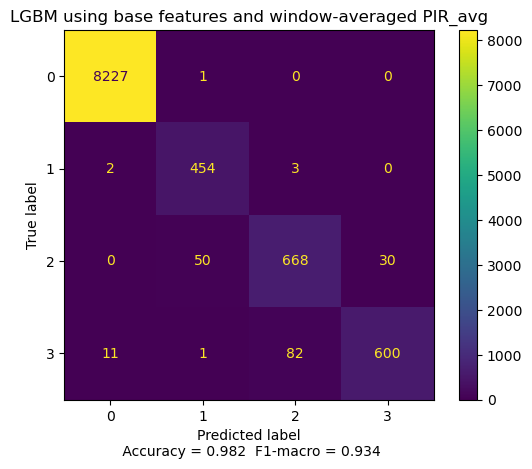

In [276]:
lgbm_predictions = cross_val_predict(std_lgbm_best, X_avg_PIR, y, groups=groups, cv=skf)
plot_confusion_acc_f1(y, lgbm_predictions, 'LGBM using base features and window-averaged PIR_avg')

### LDA

In [277]:
lda_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average_w_Edges(25), PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('lda', LinearDiscriminantAnalysis())
   ])

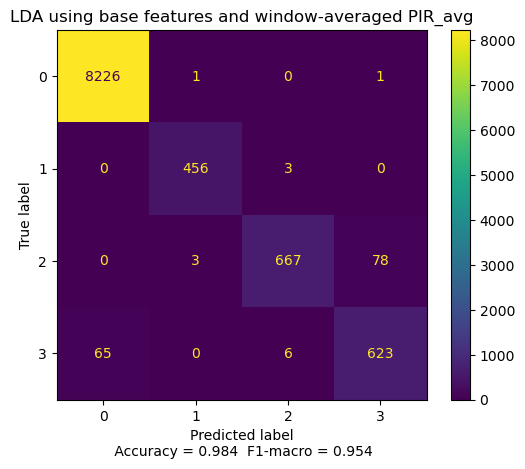

In [278]:
lda_predictions = cross_val_predict(lda_pipeline, X_avg_PIR, y, groups=groups, cv=skf)
plot_confusion_acc_f1(y, lda_predictions, 'LDA using base features and window-averaged PIR_avg')

No other model outperformed the SVC classifier in terms of both accuracy and F1-score. We will see if combining all of them into a voting classifier leads to improved performance.

## Voting classifier using best results

In [279]:
vc = VotingClassifier([
    ('svc', std_svc_best_2),
    ('knn', std_knn_best_1),
    ('rff', std_rf_best),
    ('lgbm', std_lgbm_best),
    ('lda', lda_pipeline)], 
    voting='hard')

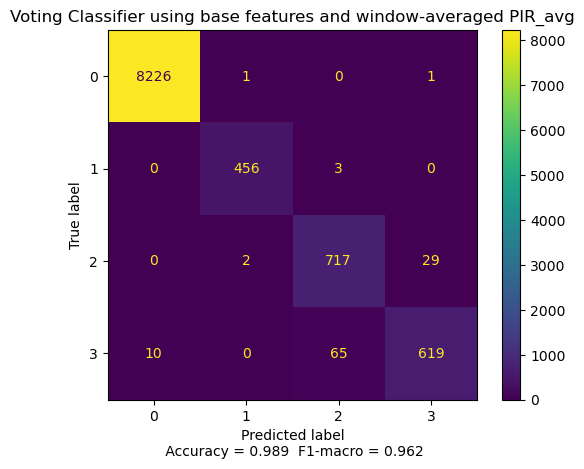

In [280]:
predictions = cross_val_predict(vc, X_avg_PIR, y, groups=groups, cv=skf, n_jobs=-1)
plot_confusion_acc_f1(y, predictions, 'Voting Classifier using base features and window-averaged PIR_avg')

The voting classifier achieved a better accuracy and f1-scores compared to SVC alone. Again improving the detection of 0 and 2 occupancy, but doing worse at identifying full occupancy states than the base model.

## Conclusion

Overall, we were able to slightly improve the classification perfomance by improving feature engineering, in particular adding a average PIR columns and averaging it over time, and by combining different estimators in a voting classifier. The improvement is small: +0.003 pts for both accuracty f1-score, therefore it is interesting to check with a statistical test if this difference is relevent when taking into account the variance of these metrics accross the different cross validation folds.

We already have the results of the 10 folds from gridsearch for the base model. We can get the results for the voting classifier.

In [281]:
vc_score = cross_validate(vc, X_avg_PIR, y, groups=groups, cv=skf, n_jobs=-1, scoring=['f1_macro','accuracy'])

In [282]:
base_f1, best_f1 = [],[]
for split in np.arange(10):
    base_f1.append(float(svc_grid_1.cv_results_[f'split{split}_test_score']))
    best_f1.append(float(vc_score['test_f1_macro'][split]))

In [283]:
#perform the Wilcoxon-Signed Rank Test
stats.wilcoxon(base_f1, best_f1)

WilcoxonResult(statistic=8.0, pvalue=0.3104944343172349)

As the $p$ value for this test is above the significance level of 0.05, we fail to reject the null hypothesis stating that the f1-score of our improved model is better than that of the model presented in the paper.

## Future work

All along this notebook, we have worked with the cross validation procedure described in the paper. I believe we would get more realistic results if the model was forced not to be evalued on instances almost identical to the ones it was trained on. By not shuffling instances in our cross validation process, we did not exacerbate this effect. However, I believe a better approach would be to use groups representing similar instances during which the occupancy does not change, as illustrated below.

In [284]:
bin_group = [0] + list(df[(df['Room_Occupancy_Count'].diff(-1))!=0].index)
df['group'] = pd.cut(df.index, bin_group, include_lowest=True, labels=np.arange(len(bin_group)-1) )

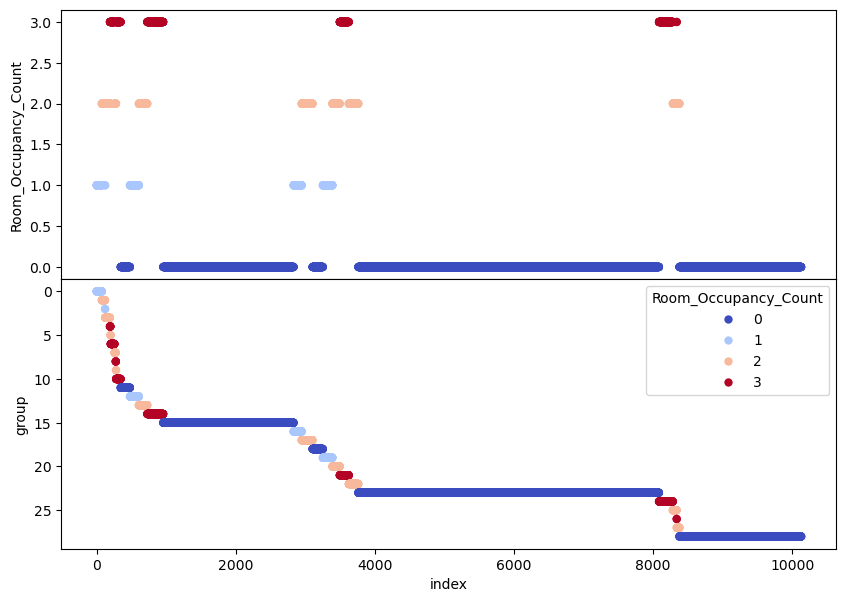

In [285]:
fig, axs = plt.subplots(2, 1, figsize = (10, 7), sharex=True)
sns.scatterplot(ax=axs[0], data=df, x=df.index, y='Room_Occupancy_Count', hue='Room_Occupancy_Count', palette='coolwarm', edgecolor="none", legend=False)
sns.scatterplot(ax=axs[1], data=df, x=df.index, y='group', hue='Room_Occupancy_Count', palette='coolwarm', edgecolor="none")
fig.subplots_adjust(hspace=0) 
axs[1].set_xlabel('index');

Here, each group represents a period of time over which the occupancy does not change. They correspond to the plateaus observed in occupancy vs time, some we can't see wihtout zooming in.

We can estimate the perfomance of the base model using these groups and the `StratifiedGroupKFold` cross validation process.

In [286]:
groups = df['group'].copy()

In [287]:
sgkf = StratifiedGroupKFold(n_splits=10)

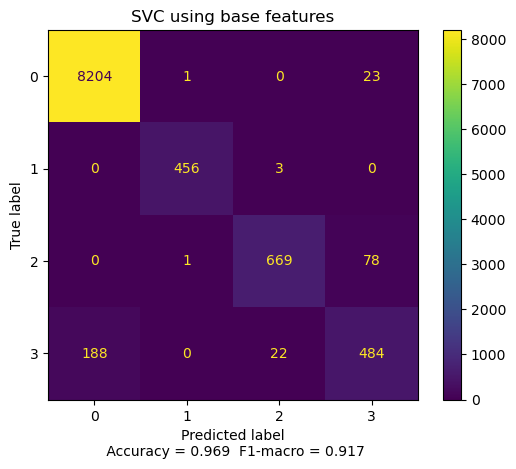

In [288]:
svc_predictions_1 = cross_val_predict(std_svc_best_1, X_base, y, groups=groups, cv=sgkf, n_jobs=-1)
plot_confusion_acc_f1(y, svc_predictions_1, 'SVC using base features')

We observe that both the accuracy and f1-score are significantly reduced. Suggesting that the previous cross validation process was overestimating the quality of our predictions. It would be interesting to extend our study using this grouped cross validation process.